# Finding Lane Lines on the Road

This is the project one for term one. The main goal is to be able to **detect/draw road lines** in a set of test provided incoming images and videos(sequential set of images).

I used [anaconda](https://www.anaconda.com/) Python flavour (version 3.6.1) and an open source library python dedicated for image and deep learning called [OpenCV](https://opencv.org/releases.html) (version 3.1.0).

For my solution proposed, the next techniques were applied:
* [Color Transformation](https://physics.info/color/).
* [Canny Edge detection](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwjA-PXnnZ7YAhVBUd8KHcCSAIkQFggqMAA&url=http%3A%2F%2Fieeexplore.ieee.org%2Fdocument%2F4767851%2F&usg=AOvVaw0W14eP78FE6nl2CmMnqDtZ).
* [ROI ( Region Of Interest) selection](https://docs.opencv.org/3.3.0/d3/df2/tutorial_py_basic_ops.html)
* [Hough line Transform](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)

This is a non exclusive list of openCV functions I used:
* [cv2.cvtColor()](https://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html) , [cv2.inRange()](https://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html), [cv2.bitwise_or()](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) , [cv2.bitwise_and()](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html). Used for color space transforms.
* [cv2.Canny()](https://docs.opencv.org/3.1.0/da/d22/tutorial_py_canny.html). Used for gradients computation(edge/borders detection).
* [cv2.GaussianBlur()](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html). Used for image filtering(2d cross correlation).
* [cv2.line()](https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html). Used to draw lines.
* [cv2.HoughLinesP()](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html). Used for Hough-image space transform.
* [cv2.addWeighted()](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html). Used for image blending.



In [65]:
# import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math



In [66]:
# realative paths

# path incoming information
pathInImgs = ('./test_images/')  # path incoming images
pathInVids = ('./test_videos/')  # path incoming videos

# path outgoing information
pathOutImgs = ('./test_images_output/')  # path incoming images
pathOutVids = ('./test_videos_output/')  # path incoming videos


Let's plot the test images:

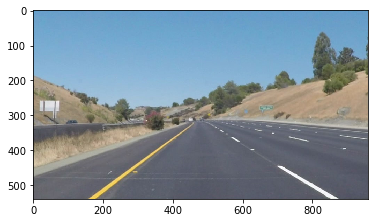

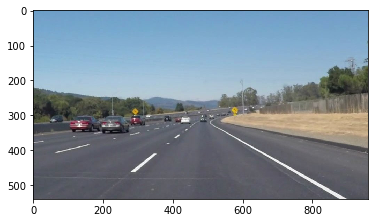

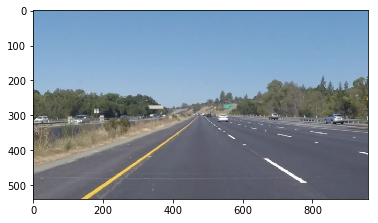

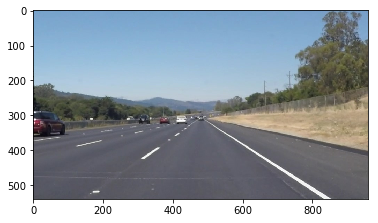

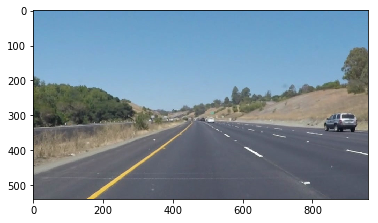

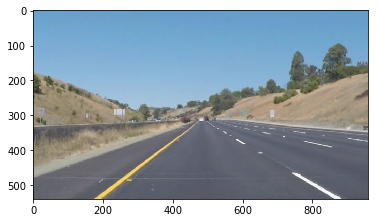

In [67]:
# Plotting test images

namesTestImgs = os.listdir('./test_images/')

# list with all test images
initialTestImgs= []
for i in range(len(namesTestImgs)):
    initialTestImgs.append(mpimg.imread(pathInImgs+namesTestImgs[i]))
    
# create copy for initial images
testImgs = np.copy(initialTestImgs)


for i in testImgs:
    plt.imshow(i)
    plt.show()
    


## Color Transformation

### RGB color space


Images where loaded in RGB color-space. Inspired on [this document](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) I decided to check what happens if I apply _(Red,Green,Blue,Yellow_ and _White)_ __masks__ in **RGB color-space** and comparing them with _(Yellow,white)_ in **HSL color-space**.

In [68]:
# 1.1 rgb white yellow mask
def rgb_wyMask(img):
    '''
    This functions returns a copy of the input image after aplying white and yellow masks in RGB space.
    
    '''
    minval= 195 # lower threshold 
    alpha= 13/16  # hyperparameter
    imgx = np.copy(img) # working with copies, not the original image.
    
    # Red Mask
    lowerRed= np.array([minval,0,0], dtype=np.uint8)
    upperRed= np.array([255,255,255], dtype=np.uint8)
    redMask= cv2.inRange(imgx, lowerRed, upperRed)
    # Green Mask
    lowerGreen= np.array([0,minval,0], dtype=np.uint8)
    upperGreen= np.array([255,255,255], dtype=np.uint8)
    greenMask= cv2.inRange(imgx, lowerGreen, upperGreen)
    # Blue Mask
    lowerBlue= np.array([0,0,minval], dtype=np.uint8)
    upperBlue= np.array([255,255,255], dtype=np.uint8)
    blueMask= cv2.inRange(imgx, lowerBlue, upperBlue)
    # Yellow Mask
    lowerYellow= np.array([minval*alpha,minval*alpha,0], dtype=np.uint8)
    upperYellow= np.array([255,255,255], dtype=np.uint8)
    yellowMask= cv2.inRange(imgx, lowerYellow, upperYellow)
    # White Mask
    lowerWhite= np.array([minval,minval,minval], dtype=np.uint8)
    upperWhite= np.array([255,255,255], dtype=np.uint8)
    whiteMask= cv2.inRange(imgx, lowerWhite, upperWhite)
    
    # Bitwise-OR
    ywMask1 = cv2.bitwise_or(yellowMask, whiteMask)   
    ywMask2 = cv2.bitwise_or(yellowMask, redMask)   
    ywMask3 = cv2.bitwise_or(yellowMask, greenMask)   
    ywMask4 = cv2.bitwise_or(yellowMask, blueMask)
    ywMask5 = cv2.bitwise_or(ywMask1, ywMask2)   
    
    # Bitwise-AND  (original_image) and (Yellow-White mask)
    ywMaskout = cv2.bitwise_and(imgx, imgx, mask = ywMask1)
    
    return ywMaskout

In [69]:
# 1.2 hls white yellow mask
def hls_wyMask(img):
    '''
    This functions returns a copy of the input image after aplying white and yellow masks in HSL space.
    
    '''
    #image in RGB space
    imgRGB = np.copy(img)
    #image in HSL space
    imgHSL = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HLS)
    # Yellow Mask
    lowerYellow= np.array([ 10, 0, 100], dtype=np.uint8)
    upperYellow= np.array([40,255,255], dtype=np.uint8)
    yellowMask= cv2.inRange(imgHSL, lowerYellow, upperYellow)
    # White Mask
    lowerWhite= np.array([ 0, 200, 0], dtype=np.uint8)
    upperWhite= np.array([255,255,255], dtype=np.uint8)
    whiteMask= cv2.inRange(imgHSL, lowerWhite, upperWhite)
    
    # Yellow or White colors passes
    ywMask1 = cv2.bitwise_or(yellowMask, whiteMask)
    # Bitwise-AND  (hls_image) and (Yellow-White mask)
    ywMaskout = cv2.bitwise_and(imgRGB, imgRGB, mask = ywMask1)

    return ywMaskout

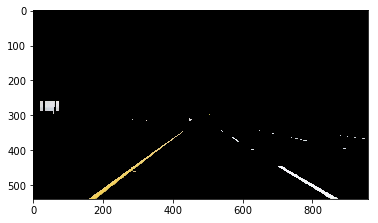

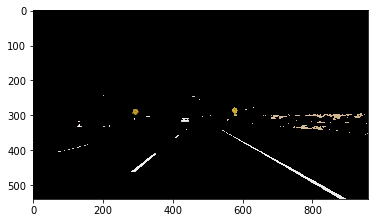

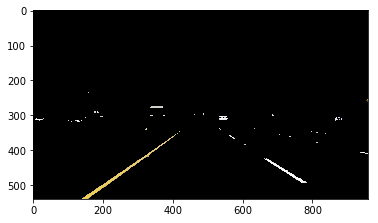

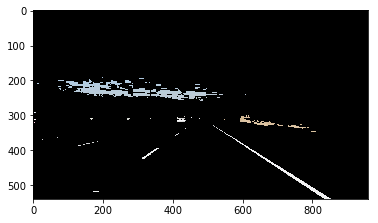

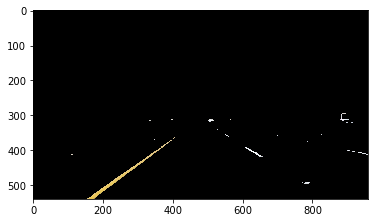

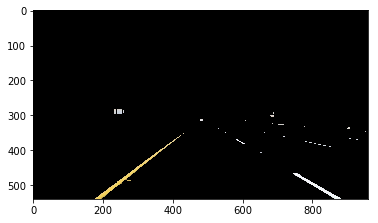

In [72]:
# Comparing RGB and HLS color spaces

hlsImgs = []
for i in range(len(testImgs)):
    plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.imshow(rgb_wyMask(testImgs[i]))
    #plt.subplot(1, 2, 2)
    plt.imshow(hls_wyMask(np.copy(testImgs[i])))
    hlsImgs.append(hls_wyMask(np.copy(testImgs[i])))
    plt.show()
    
    #out_filename= ( './step_by_step_images/a_rgb-mask/'+str(i)+'.png' )
    #plt.imsave(out_filename, rgb_wyMask(np.copy(testImgs[i])) , format='png')
    out_filename= ( './step_by_step_images/b_hls-mask/'+str(i)+'.png' )
    plt.imsave(out_filename, hls_wyMask(np.copy(testImgs[i])) , format='png')
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()
    

In HSL color-space _yellow line_ is better defined than in RGB color-space. So I decided to work with _images filtered_ in HSL color-space.

For yellow color:
* Hue > 30
* Ligh = 0 = Not filtered
* Saturation > 90

For white color:
* Hue = 0 = not filtered
* Ligh >= 200
* Saturation = 0 = Not filtered
    

## Canny Edge detection

To find high gradient values to detect borders on images _openCV implementation for canny algorithm_ was used.

### Gray scale Images

Before appying _canny algorithm_ images are mapped to _gray-scale_ representation.

In [73]:
# 2. convert image to gray-scale
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


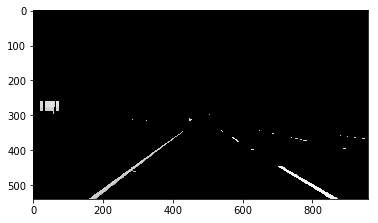

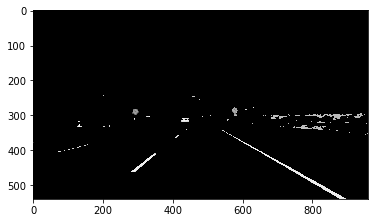

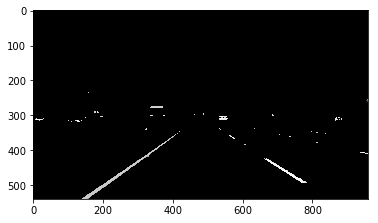

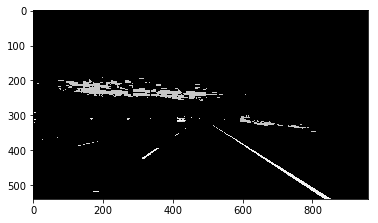

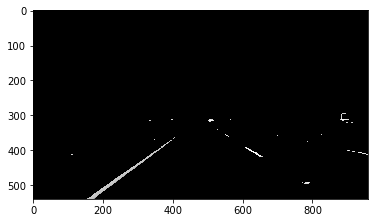

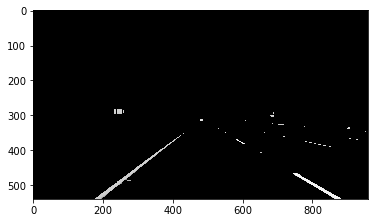

In [74]:
grayImgs= []
# Comparing RGB and HLS color spaces
for i in range(len(testImgs)):
    #plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.imshow(hlsImgs[i])
    #plt.subplot(1, 2, 2)
    plt.imshow(grayscale(np.copy(hlsImgs[i])), cmap='gray')
    grayImgs.append( grayscale(np.copy(hlsImgs[i])) )
    plt.show()
    
    out_filename= ( './step_by_step_images/c_gray-scale/'+str(i) )
    plt.imsave(out_filename, grayscale(np.copy(hlsImgs[i])) , cmap=plt.cm.gray)
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

### Gaussian Blur

To avoid noise edge detection image is smoothed so that gradients (pixel intensity variations) can be detected easier. For that [cv2.GaussianBlur()](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html) was used. I used kernel size = filter size = 15.

In [75]:
# 3. Gaussian blur
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

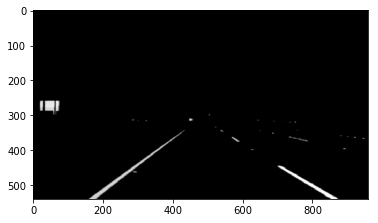

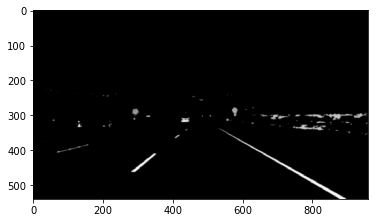

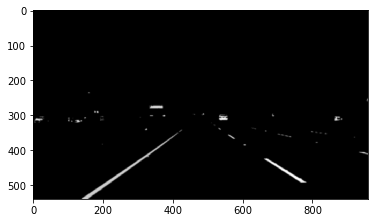

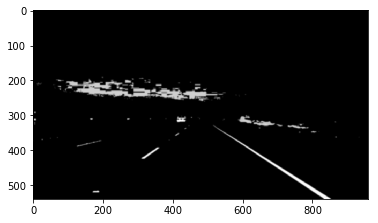

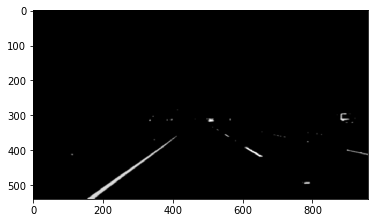

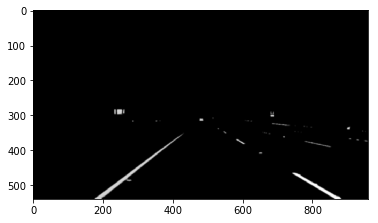

In [77]:
blurImgs= []
# Comparing RGB and HLS color spaces
for i in range(len(testImgs)):
    #plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.imshow(blurImgs[i])
    #plt.subplot(1, 2, 2)
    plt.imshow(gaussian_blur(np.copy(grayImgs[i]), 7), cmap='gray')
    blurImgs.append(gaussian_blur(np.copy(grayImgs[i]), 7))
    plt.show()
    
    out_filename= ( './step_by_step_images/d_gaussian-blur/'+str(i)+'.png' )
    plt.imsave(out_filename, gaussian_blur(np.copy(grayImgs[i]), 7) , cmap=plt.cm.gray)
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

### Borders detection

Acording to documentation [cv2.Canny()](https://docs.opencv.org/3.1.0/da/d22/tutorial_py_canny.html), lower and upper threshold for border detection must be adjusted. However, is recommended in [here](https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html) to use a _upper:lower_ ratio between **2:1** and **3:1**.

Following values were selected:
* Upper threshold: 150
* Lower threshold: 50
* _upper:lower_ ratio : 150/50 = 3:1

In [78]:
# 4. Edge detection
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

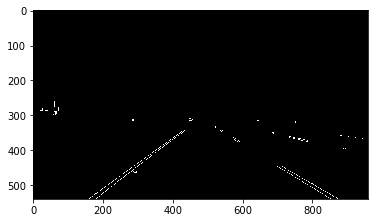

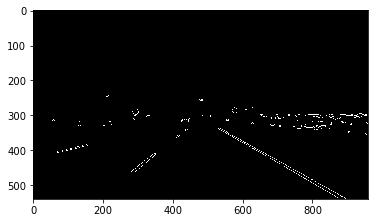

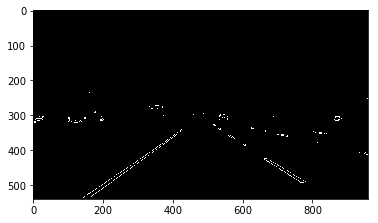

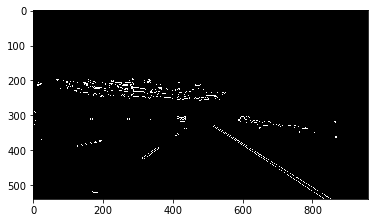

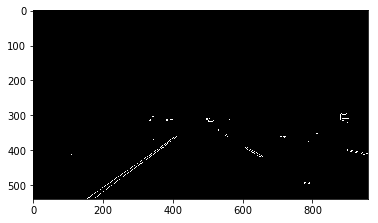

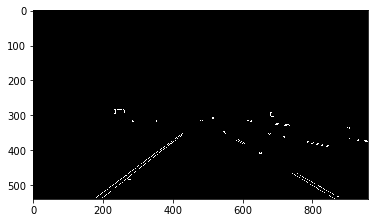

In [80]:
edgeImgs= []
# Finding image gradients
for i in range(len(testImgs)):
    #plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.imshow(blurImgs[i])
    #plt.subplot(1, 2, 2)
    plt.imshow(canny(np.copy(blurImgs[i]), 50,150), cmap='gray')
    edgeImgs.append(canny(np.copy(blurImgs[i]), 50,150))
    plt.show()
    
    out_filename= ( './step_by_step_images/e_canny/'+str(i)+'.png' )
    plt.imsave(out_filename, canny(np.copy(blurImgs[i]), 50,150) , cmap=plt.cm.gray)
    
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

#### Morphological Transformations

After aplying canny edge detection. Noticed there are non continuous lines at the edge of _left-right_ road lines regions. So to reduce noise in the averaged _left-line region_ and _rigth-line region_, than is , to close up open regions [dilatation followed by erosion](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#dilation) was applied.

In [121]:
# 4.2 Closing regions
def closing_regions(img, kernel=np.ones((3,3),np.uint8)):
    dilatation = cv2.dilate(img,kernel,iterations = 1)
    erosion = cv2.erode(dilatation,kernel,iterations = 1)
    
    closed = erosion
    return closed

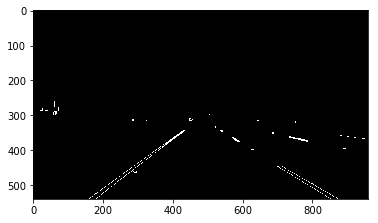

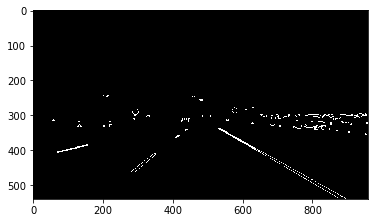

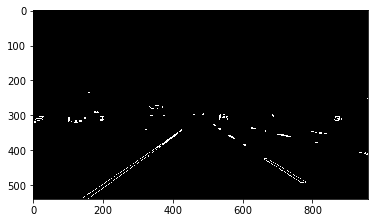

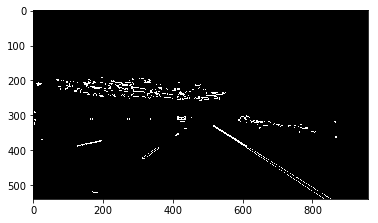

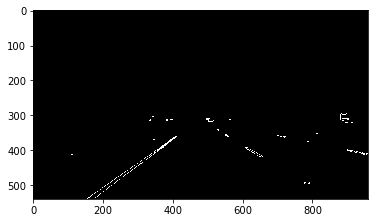

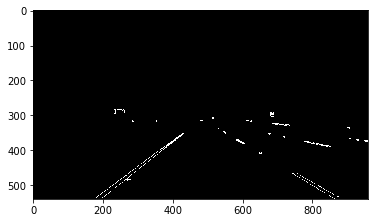

In [123]:
edgeclosedImgs= []
# closing regions
for i in range(len(testImgs)):
    #plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.imshow(blurImgs[i])
    #plt.subplot(1, 2, 2)
    plt.imshow(closing_regions(np.copy(edgeImgs[i]),kernel=np.ones((3,3),np.uint8)), cmap='gray')
    edgeclosedImgs.append(closing_regions(np.copy(edgeImgs[i]),kernel=np.ones((3,3),np.uint8)))
    plt.show()
    
    out_filename= ( './step_by_step_images/f_dilate-erode/'+str(i)+'.png' )
    var = closing_regions(np.copy(edgeImgs[i]),kernel=np.ones((3,3),np.uint8))
    plt.imsave(out_filename, var , cmap=plt.cm.gray)
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

## Region Of Interest (ROI) selection

### Generate image vertices

First off of, to reduce problem complexity, a focus region was introduced.

**Note:** At first attempt morphological transformation was not applied , so, averaged regions became noisy. To Improve that, my first insight was to  try different regions looking for noising out _spurious-contours_ close to the _left-rigth_ lines. I tried different region-shapes. But then I realized **most of power image noise ** is highly present in **non-closed** image regions. So I used the first polygon I initially tried out, a _truncated-triangle = trapezium_.

** Note2:** region vertices position calibration was done by _trial-error_. So, there should be an algorith to recalibrate those points while car is on the road, and the points here presented should be interpreted as _points-localization initialization_.

In [124]:
# 5.1 Generate image vertices
def generate_vertices(img):

    #h,w,d= img.shape  # this line is for width x heigh x depht images
    h,w= img.shape     # this line is for width x heigh images
    out_downLeft = [0.15*w, 0.99*h]
    out_upLeft   = [0.43*w, 0.6*h]
    out_upRigth  = [0.58*w, 0.6*h]
    out_downRigth= [0.98*w, 0.99*h]
    
    in_downRigth=  [0.6*w, 0.96*h]
    in_upRigth  =  [0.52*w, 0.6*h]
    in_upLeft   =  [0.48*w, 0.6*h]
    in_downLeft =  [0.4*w, 0.96*h]
    
    #vertices= np.array([[ out_downLeft, out_upLeft, out_upRigth, out_downRigth, in_downRigth, in_upRigth, in_upLeft, in_downLeft ]], dtype= np.int32)
    vertices= np.array([[ out_downLeft, out_upLeft, out_upRigth, out_downRigth ]], dtype= np.int32)
    return vertices

### Image mask-out

Region of interest selection was applied on preprocesed image by **blacking-out ** positions _out of selected shape_.

In [125]:
# 5.2 Mask image into polygon
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a zeros-mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

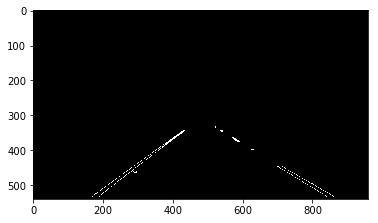

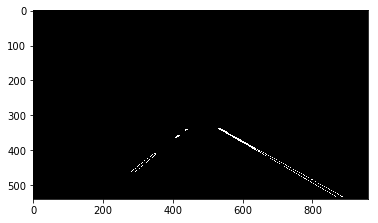

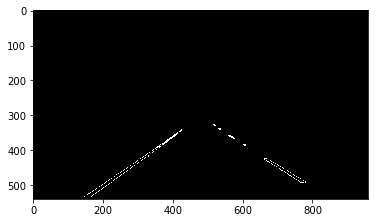

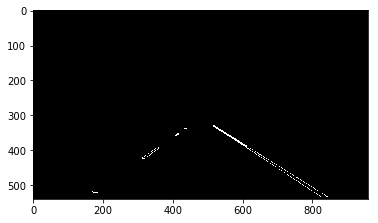

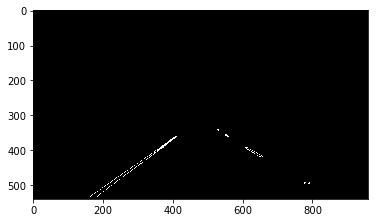

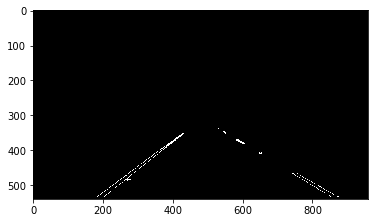

In [128]:
# 5.2 Mask image into polygon
regionImgs= []
for i in range(len(testImgs)):
    #plt.figure()
    #plt.subplot(1, 2, 1)
    #plt.imshow(testImgs[i])
    #plt.subplot(1, 2, 2)
    vertices = generate_vertices(np.copy(edgeclosedImgs[i]))
    plt.imshow(region_of_interest(np.copy(edgeclosedImgs[i]),vertices), cmap='gray')
    regionImgs.append(region_of_interest(np.copy(edgeclosedImgs[i]),vertices))
    plt.show()
    
    out_filename= ( './step_by_step_images/g_region-mask/'+str(i)+'.png' )
    var = region_of_interest(np.copy(edgeclosedImgs[i]),vertices)
    plt.imsave(out_filename, var , cmap=plt.cm.gray)
    
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

## Hough Transform

Once image is preprocessed and the region of interest is selected, **hough transform** is applied to find a set of posible detected lines that afterwards will be narrow down/average out.

In [145]:
# 6.2 draw posible lines (set of lines) along the road lines
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    imgx = np.copy(img)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(imgx, (x1, y1), (x2, y2), color, thickness)
    
    return imgx

In [146]:
# 6.1 compute hough transform
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = draw_lines(line_img, lines)
    return line_img, lines

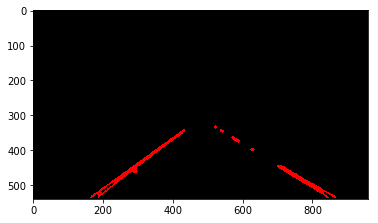

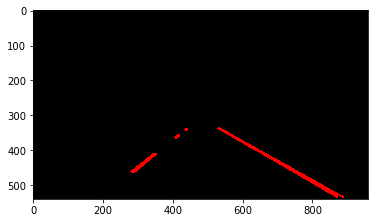

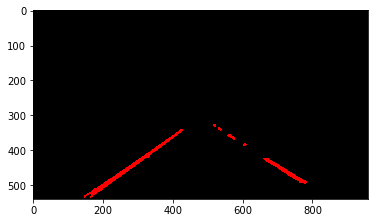

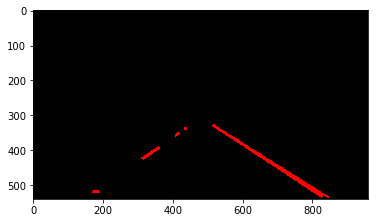

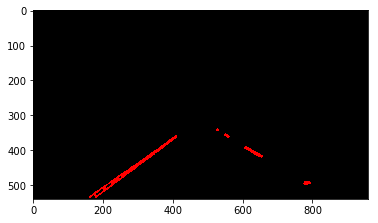

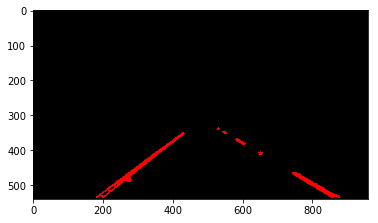

In [153]:
# 6.1 compute hough transform
posslinesImgs= []
possibleLines= []
for i in range(len(testImgs)):
    xpoints,xlines = hough_lines(np.copy(regionImgs[i]), rho=1, theta= 1*np.pi/180, threshold=1, min_line_len= 1, max_line_gap= 10)
    plt.imshow(xpoints)
    posslinesImgs.append(xpoints)
    possibleLines.append(xlines)
    plt.show()
    
    out_filename= ( './step_by_step_images/h_hough-transform/'+str(i)+'.png' )
    var = xpoints
    plt.imsave(out_filename, var , cmap=plt.cm.gray)
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

So, the _set of possible lines_ on the road looks as follows:

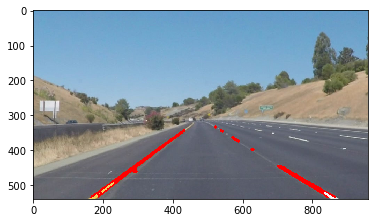

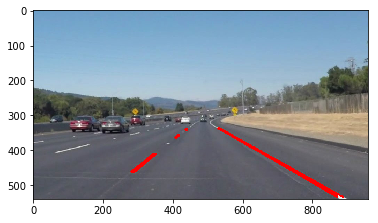

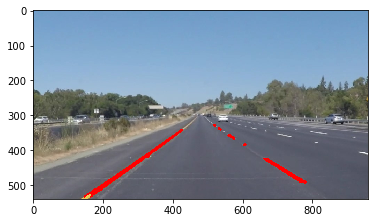

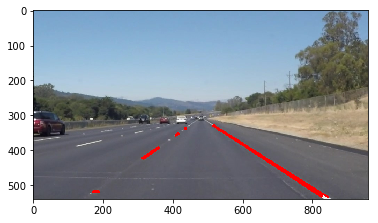

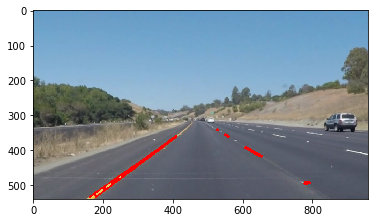

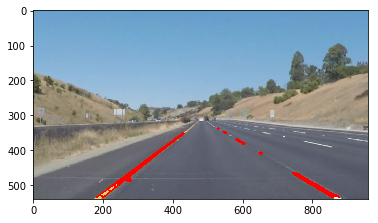

In [154]:
# 6.2 draw posible lines (set of lines) along the road lines
testImgscopy1= np.copy(testImgs)

for i in range(len(testImgs)):
    testImgscopy1[i] = draw_lines(np.copy(testImgs[i]),np.copy(possibleLines[i]) , color=[255, 0, 0], thickness=3)
    plt.imshow(testImgscopy1[i])
    plt.show()
    
    out_filename= ( './step_by_step_images/i_lines-on-road/'+str(i)+'.png' )
    var = testImgscopy1[i]
    plt.imsave(out_filename, var)
    
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

## Defining Pipeline

Now, a summary function **process_image** is defined, so that **it returns** the processed image.

In [274]:


# import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

# realative paths

# path incoming information
pathInImgs = ('./test_images/')  # path incoming images
pathInVids = ('./test_videos/')  # path incoming videos

# path outgoing information
pathOutImgs = ('./test_images_output/')  # path incoming images
pathOutVids = ('./test_videos_output/')  # path incoming videos

namesTestImgs = os.listdir('./test_images/')
# list with all test images
initialTestImgs= []
for i in range(len(namesTestImgs)):
    initialTestImgs.append(mpimg.imread(pathInImgs+namesTestImgs[i]))
    
# create copy for initial images
testImgs = np.copy(initialTestImgs)
testImgscopy1= np.copy(testImgs)

#for i in testImgs:
#    plt.imshow(i)
#    plt.show()
    


def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    img= np.copy(image)
    imgx= np.copy(image)
    
    hlsImg = np.zeros_like(img)
    grayImg= np.zeros_like(img)
    blurImg= np.zeros_like(img)
    edgeImg= np.zeros_like(img)
    edgeclosedImg= np.zeros_like(img)
    regionImg= np.zeros_like(img)
    posslinesImg= np.zeros_like(img)
    possibleLines= np.zeros_like(img)
    
    
    hlsImg = hls_wyMask(np.copy(img))
    grayImg= grayscale(np.copy(hlsImg))
    blurImg= gaussian_blur(np.copy(grayImg), 7)
    edgeImg= canny(np.copy(blurImg), 50, 150)
    edgeclosedImg= closing_regions( np.copy(edgeImg), kernel= np.ones((3,3),np.uint8) )
    
    vertices = generate_vertices(np.copy(edgeclosedImg))
    regionImg= region_of_interest( np.copy(edgeclosedImg), vertices)
    
    xpoints,xlines = hough_lines( np.copy(regionImg), rho=1, theta= 1*np.pi/180, threshold=5, min_line_len=5, max_line_gap= 15)
    posslinesImg= xpoints
    possibleLines= xlines
    
    imgx= draw_lines(imgx, possibleLines, color=[255, 0, 0], thickness=3)
    
    result = imgx
    #plt.imshow(result)
    #plt.show()
    
    return result


    
    

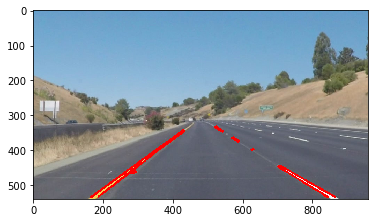

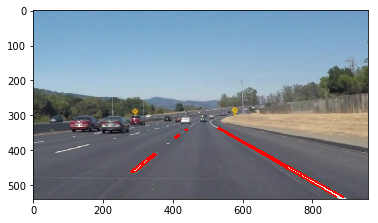

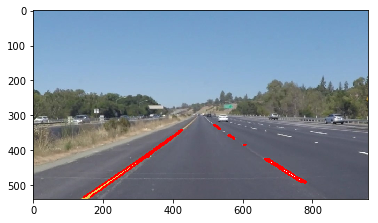

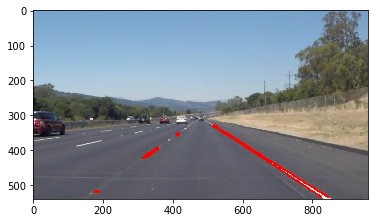

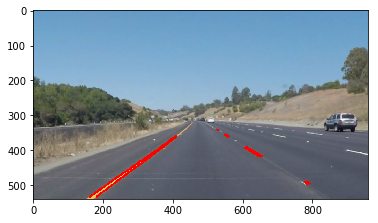

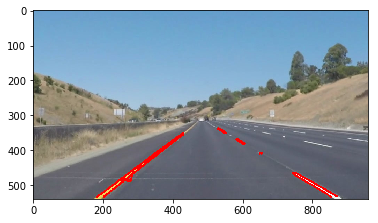

In [275]:
# Showing possible lines for the lines on the road
for i in range(len(testImgs)):
    plt.imshow(process_image(testImgs[i]))
    plt.show()
    
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

In [276]:
# Getting possible lines for the lines on the road for video1
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/red_linesv2_solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/red_linesv2_solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/red_linesv2_solidWhiteRight.mp4


 99%|█████████▉| 125/126 [00:08<00:00, 15.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/red_linesv2_solidWhiteRight.mp4 



In [277]:
# Getting possible lines for the lines on the road for video2
from moviepy.editor import VideoFileClip
from IPython.display import HTML

yellow_output = 'test_videos_output/red_linesv2_solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/red_linesv2_solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/red_linesv2_solidYellowLeft.mp4


 99%|█████████▉| 125/126 [00:08<00:00, 14.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/red_linesv2_solidYellowLeft.mp4 



In [278]:
# Getting possible lines for the lines on the road for video2
from moviepy.editor import VideoFileClip
from IPython.display import HTML

challenge_output = 'test_videos_output/red_linesv2_challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
#clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/red_linesv2_challenge.mp4
[MoviePy] Writing video test_videos_output/red_linesv2_challenge.mp4


 99%|█████████▉| 125/126 [00:16<00:00,  4.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/red_linesv2_challenge.mp4 



## connect/average/extrapolate output lines

On this subsection, output _predicted road lines_ are averaged out so than _a single representative line_ as output lane line is shown, one for the left side and one for the right side.

So, function **draw_lines** used in the hough transformation step is now modified as follows:

In [322]:
def draw_lines2(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    imgx = np.copy(img)
    
    mList= []
    bList= []
    l2NormList= []
    
    leftLines = []
    leftWeights = []
    rightLines = []
    rightWeights = []
    zeroLines = []
    zeroWeights= []
    
    ipsylum = 0.2
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(imgx, (x1, y1), (x2, y2), color, thickness)
            
            m= ((y2-y1)/(x2-x1))
            b= y2 -m*x2
            l2Norm= np.sqrt( ((y2-y1)**2) + ((x2-x1)**2))
            mList.append(m)
            bList.append(b)
            l2NormList.append(l2Norm)
            
            if m > ipsylum:
                leftLines.append(np.array([m,b], dtype=np.float32))
                leftWeights.append(l2Norm)
            elif m < -ipsylum:
                rightLines.append(np.array([m,b], dtype=np.float32))
                rightWeights.append(l2Norm)
            else:
                zeroLines.append(np.array([m,b], dtype=np.float32))
                
            
            if len(leftWeights)>0:
                lineLeftt= np.average(np.asarray(leftLines), axis=0)
                #lineLeftt= np.dot(leftWeights, leftLines)/(np.sum(leftWeights))
            #else:
            #    None
                
            if len(rightWeights)>0:
                lineRigthh= np.average(np.asarray(rightLines), axis=0)
                #lineRigthh = np.dot(rightWeights, rightLines)/(np.sum(rightWeights))
            #else:
            #    None
                
    #if len(leftWeights) = 0:
    #    lineLeftt
                 
            
    return mList, bList, l2NormList, leftLines, rightLines, zeroLines,leftWeights, rightWeights, lineLeftt, lineRigthh

Here two variables are the important ones (**lineL, lineR**). The other variables where used to debug possible np.Nan returned values or empty list values.

Resuming image processing since **hough transform**

In [364]:
# 6.1 compute hough transform
posslinesImgs= []
possibleLines= []
for i in range(len(testImgs)):
    xpoints,xlines = hough_lines(np.copy(regionImgs[i]), rho=1.2, theta= 1*np.pi/180, threshold=10, min_line_len= 10, max_line_gap= 5)
    
    posslinesImgs.append(xpoints)
    possibleLines.append(xlines)
    #plt.imshow(posslinesImgs[i])
    #plt.show()

# 7.1. get averaged (slope, b) for each line (Note: just lineL  and lineR are the important variables, the other ones are just for debugging purposes)
mlist= []
blist= []
l2normlist= []
linesL= []
linesR= []
zeroL= []
weightsL= []
weightsR= []
lineL= []
lineR= []

for i in range(len(testImgs)):
    [mlistx, blistx, l2normlistx, linesLx, linesRx, zeroLx, weightsLx, weightsRx, lineLx, lineRx]=draw_lines2(np.copy(testImgs[i]), possibleLines[i], color=[255, 0, 0], thickness=3)
    lineL.append(lineLx)
    lineR.append(lineRx)
    mlist.append(mlistx)


    print(lineRx)


#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

[  -0.76114047  672.07275391]
[  -0.76497197  676.97509766]
[  -0.67465597  638.31994629]
[  -0.68795103  639.11602783]
[  -0.70165431  650.41033936]
[  -0.79857308  694.08203125]


### Get image pixels for averaged lines

Here:
* Aproximated _left_ and _rigth_ linear functions are maped-back to the image space. 
* A helper function to return _averaged left-rigth lines_ as an array is defined.
* The provided helper function *weigthed_img* is used to aply trasnsparency to the predicted lines.
* Finally, predicted lines are painted over a copy of the original image.

In [365]:
# 7.1 get image pixels for averaged lines

def aproximated_lr_lines(img, avgLine, λ):
    m = avgLine[0]
    b = avgLine[1]
    
    y2 = img.shape[0]
    y1 = λ*y2
    
    x2 = (y2 -b)/m
    x1 = (y1 -b)/m
    
    #if np.isnan(x1):
    #    x1 = (y1 -b)/(0.1
    #if np.isnan(x2):
    #    x1=0
    
    
    return int(x1), int(y1), int(x2), int(y2)

In [366]:
# 7.2 get left and rigth lines in format ready to be introduced to draw_lines3

def avgLines_as_array(img, lineL, lineR):
    img2= np.zeros_like(img)
    lines2 = np.zeros((2,1,4),dtype= np.int32)
    
    lines2[0][0] =  np.asarray( aproximated_lr_lines(img2, lineL, 0.6), dtype= np.int32 )
    lines2[1][0] =  np.asarray( aproximated_lr_lines(img2, lineR, 0.6), dtype= np.int32 )

    return lines2

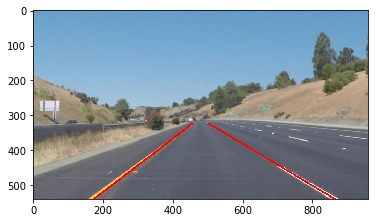

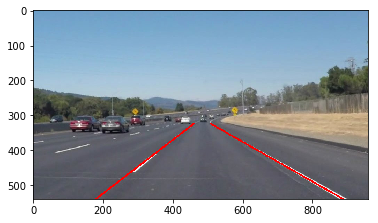

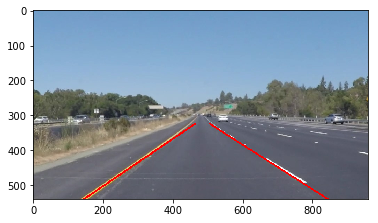

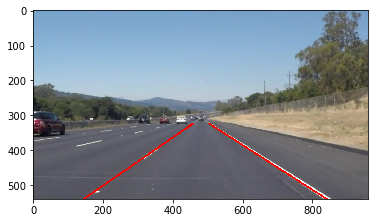

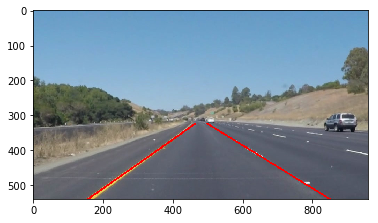

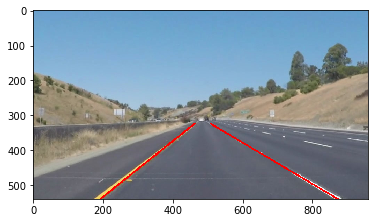

In [367]:
# 7.2 get left and rigth lines averaged aproximations


regionImgs3 = np.copy(regionImgs)
testImgscopy3 = np.copy(testImgs)

lines3= []
for i in range(len(testImgs)):
    lines3.append( avgLines_as_array(np.copy(regionImgs3[i]), lineL= lineL[i], lineR= lineR[i])  )
    testImgscopy3[i] = draw_lines(np.copy(testImgscopy3[i]), lines3[i], color=[255, 0, 0], thickness=3)
    plt.imshow(testImgscopy3[i])
    plt.show()
    
    out_filename= ( './step_by_step_images/j_aproximated-lines-on-road/'+str(i)+'.png' )
    var = testImgscopy3[i]
    plt.imsave(out_filename, var)
#for i in range(len(testImgs)):
#   plt.imshow(testImgs[i])
#   plt.show()

In [368]:
# 8. include the option to get weighted images = trasparency in lines

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [369]:
# 9. predicted lines painted over original image

def lines_on_image(initial_img, linesx,alpha=0.7, betha=0.5, color=[255, 0, 0], thickness=12):
    imx = np.zeros_like(initial_img)
    
    imx = draw_lines(np.copy(imx), linesx, color=color, thickness=thickness)
    dst = weighted_img(imx, initial_img, α= alpha, β= betha, λ=0.0)
    
    return dst

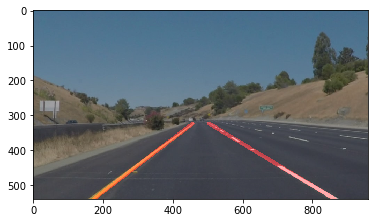

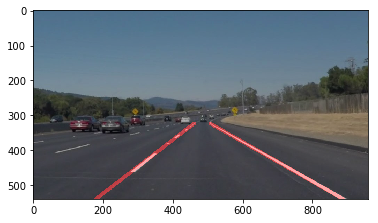

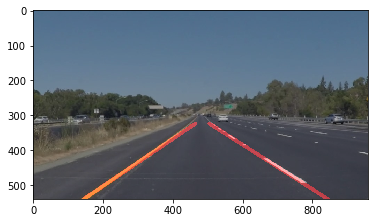

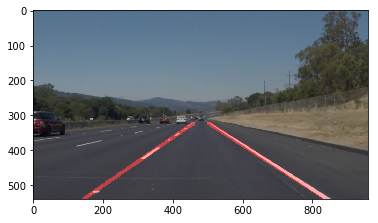

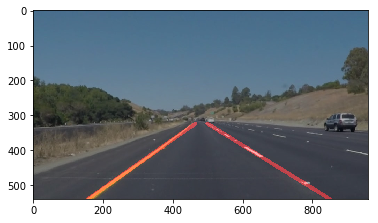

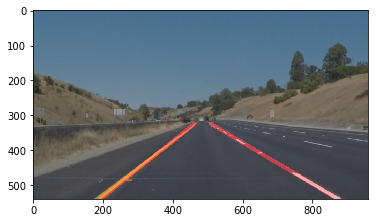

In [370]:
# 9. predicted lines painted over original image
for i in range(len(testImgs)):
    dst = lines_on_image(np.copy(testImgs)[i], lines3[i], alpha=0.7, betha=0.5, color=[255, 0, 0], thickness=10)
    plt.imshow(dst)
    plt.show()

    out_filename= ( './step_by_step_images/k_aproximated-lines-on-road-transparency/'+str(i)+'.png' )
    var = dst
    plt.imsave(out_filename, var)
    
    
#for i in range(len(testImgs)):
#   plt.imshow(testImgs[i])
#   plt.show()

**Note:** As you can see on the previous images, predicted lines are little deviated from the real road lines, so perturbations/wavy/noisy predicted lines are expected.

### Pipeline for averaged lines

Now, a summary function **process_image2** is defined, so that **it returns** the processed image for the averaged lines.

In [398]:


# import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

# realative paths

# path incoming information
pathInImgs = ('./test_images/')  # path incoming images
pathInVids = ('./test_videos/')  # path incoming videos

# path outgoing information
pathOutImgs = ('./test_images_output/')  # path incoming images
pathOutVids = ('./test_videos_output/')  # path incoming videos

namesTestImgs = os.listdir('./test_images/')
# list with all test images
initialTestImgs= []
for i in range(len(namesTestImgs)):
    initialTestImgs.append(mpimg.imread(pathInImgs+namesTestImgs[i]))
    
# create copy for initial images
testImgs = np.copy(initialTestImgs)
testImgscopy1= np.copy(testImgs)

#for i in testImgs:
#    plt.imshow(i)
#    plt.show()
    


def process_image2(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    img= np.copy(image)
    imgx= np.copy(image)
    
    hlsImg = np.zeros_like(img)
    grayImg= np.zeros_like(img)
    blurImg= np.zeros_like(img)
    edgeImg= np.zeros_like(img)
    edgeclosedImg= np.zeros_like(img)
    regionImg= np.zeros_like(img)
    posslinesImg= np.zeros_like(img)
    possibleLines= np.zeros_like(img)
    
    
    hlsImg = hls_wyMask(np.copy(img))
    grayImg= grayscale(np.copy(hlsImg))
    blurImg= gaussian_blur(np.copy(grayImg), 7)
    edgeImg= canny(np.copy(blurImg), 50, 150)
    edgeclosedImg= closing_regions( np.copy(edgeImg), kernel= np.ones((3,3),np.uint8) )
    
    vertices = generate_vertices(np.copy(edgeclosedImg))
    regionImg= region_of_interest( np.copy(edgeclosedImg), vertices)
    
    xpoints,xlines = hough_lines( np.copy(regionImg), rho=1, theta= 1*np.pi/180, threshold=10, min_line_len= 10, max_line_gap= 1)
    
    posslinesImg= xpoints
    possibleLines= xlines
    [mlistx, blistx, l2normlistx, linesLx, linesRx, zeroLx, weightsLx, weightsRx, lineLx, lineRx]= draw_lines2(np.copy(imgx), possibleLines, color=[255, 0, 0], thickness=3)
    print(lineLx)
    print(lineRx)
    #print(xlines)
    
    lines3= avgLines_as_array( np.copy(regionImg), lineL= lineLx, lineR= lineRx )
    
    #imgx= draw_lines(imgx, possibleLines, color=[255, 0, 0], thickness=1)
    dst= lines_on_image(np.copy(imgx), lines3, alpha=0.7, betha=0.5, color=[255, 0, 0], thickness=10)
    
    result = dst
    #plt.imshow(result)
    #plt.show()
    
    return result


    
    

[  0.56657481  44.58625412]
[  -0.7570833   669.78704834]


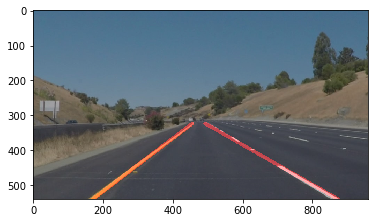

[  0.56657481  44.58625412]
[  -0.7570833   669.78704834]
[  0.5994947   16.02176857]
[  -0.79304373  688.49078369]


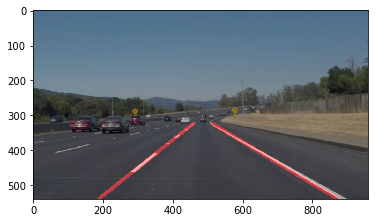

[  0.5994947   16.02176857]
[  -0.79304373  688.49078369]
[  0.60289377  22.34674072]
[  -0.75663966  663.95959473]


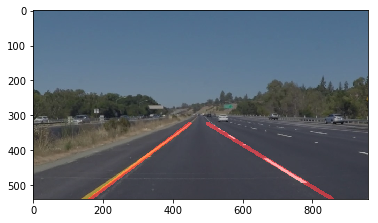

[  0.60289377  22.34674072]
[  -0.75663966  663.95959473]
[  0.62313145  13.13710213]
[  -0.68146306  636.9362793 ]


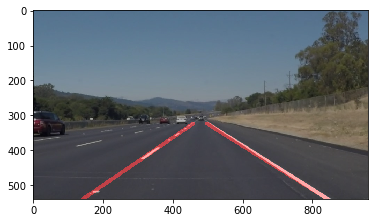

[  0.62313145  13.13710213]
[  -0.68146306  636.9362793 ]
[  0.59238386  30.42801285]
[  -0.74505234  665.89868164]


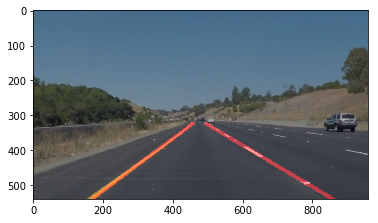

[  0.59238386  30.42801285]
[  -0.74505234  665.89868164]
[  0.55107784  51.43190765]
[  -0.77790135  687.15667725]


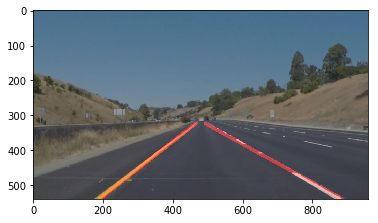

[  0.55107784  51.43190765]
[  -0.77790135  687.15667725]


In [407]:
# Showing possible lines for the lines on the road

for i in range(len(testImgs)):
    plt.imshow(process_image2(testImgs[i]))
    plt.show()

    
    out_filename= ( './test_images_output/'+'copy_'+str(namesTestImgs[i])+'.png' )
    var = process_image2(testImgs[i])
    plt.imsave(out_filename, var)

#for i in range(len(testImgs)):
#    plt.imshow(process_image2(testImgs[i]))
#    plt.show()
    
#for i in range(len(testImgs)):
#    plt.imshow(testImgs[i])
#    plt.show()

In [402]:
# Getting possible lines for the lines on the road for video1
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/averaged_linesv2_solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image2) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[  0.65123451 -13.24929047]
[  -0.72586334  652.49316406]
[MoviePy] >>>> Building video test_videos_output/averaged_linesv2_solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/averaged_linesv2_solidWhiteRight.mp4





  0%|          | 0/126 [00:00<?, ?it/s]


  2%|▏         | 3/126 [00:00<00:05, 24.20it/s]

[  0.65123451 -13.24929047]
[  -0.72586334  652.49316406]
[  0.60053581  18.42386436]
[  -0.75218499  660.50427246]
[  0.60010284  21.89677238]
[  -0.74664128  659.2925415 ]


[  0.60620081  16.98278236]
[  -0.73203814  655.49053955]





  4%|▍         | 5/126 [00:00<00:06, 19.36it/s]

[ 0.63586229 -2.0256424 ]
[  -0.72516918  651.60406494]
[  0.58628589  27.56774902]
[  -0.73332149  654.75177002]
[  0.59994453  20.59012413]
[  -0.69783551  640.71844482]





  6%|▋         | 8/126 [00:00<00:05, 20.46it/s]

[  0.58825988  24.04430199]
[  -0.70795459  643.49890137]
[  0.60035491  18.91477776]
[  -0.75104636  660.36676025]





  8%|▊         | 10/126 [00:00<00:05, 19.49it/s]

[  0.6042549   20.79108429]
[  -0.74248314  659.24688721]
[  0.60706007  21.20948219]
[  -0.70571148  646.70263672]





 10%|▉         | 12/126 [00:00<00:05, 19.57it/s]

[  0.58942002  34.3352623 ]
[  -0.73397136  655.6005249 ]
[ 0.63050079  5.1931448 ]
[  -0.74136633  657.61102295]
[  0.60918766  20.71880341]
[  -0.71701932  649.88354492]





 12%|█▏        | 15/126 [00:00<00:05, 20.02it/s]

[  0.61819136  13.57868767]
[  -0.73108006  652.60003662]
[ 0.63601726 -2.26364827]
[  -0.72072411  643.67999268]





 14%|█▍        | 18/126 [00:00<00:05, 21.04it/s]

[ 0.6298427   1.80955708]
[  -0.69861108  637.71942139]
[ 0.62558341  5.83965397]
[  -0.67320532  629.22711182]
[  0.65154499 -10.26009178]
[  -0.6472702   621.72436523]





 16%|█▌        | 20/126 [00:01<00:05, 19.46it/s]

[  0.61987787  15.43163395]
[  -0.69535816  640.94116211]





 17%|█▋        | 22/126 [00:01<00:05, 18.00it/s]

[ 0.63314915  5.41979218]
[  -0.71203798  646.48779297]
[ 0.63305354  4.647614  ]
[  -0.68289602  636.64678955]
[  0.6194905   15.93212891]
[  -0.74534345  661.72265625]


[ 0.62474704  8.11742783]




 19%|█▉        | 24/126 [00:01<00:06, 15.70it/s]


 21%|██        | 26/126 [00:01<00:06, 15.39it/s]


[  -0.72369355  650.6072998 ]
[  0.61932409  11.20170689]
[  -0.72999436  651.39849854]
[ 0.62452775  9.03790188]
[  -0.74958068  660.10522461]
[  0.62459153  11.38738537]
[  -0.70749277  645.53094482]





 22%|██▏       | 28/126 [00:01<00:05, 16.35it/s]


 25%|██▍       | 31/126 [00:01<00:05, 18.19it/s]

[ 0.62402862  9.06690979]
[  -0.72040707  653.02905273]
[ 0.62419629  8.32141781]
[  -0.72487235  653.02148438]
[  0.62065119  11.99170971]
[  -0.76269841  665.39129639]
[ 0.63174975  1.02164197]
[  -0.7175709  649.4296875]
[  0.58822513  31.02754784]
[  -0.70100981  642.04400635]





 26%|██▌       | 33/126 [00:01<00:05, 18.45it/s]


 29%|██▊       | 36/126 [00:01<00:04, 20.02it/s]

[ 0.6232447   7.42045212]
[  -0.72074211  649.78710938]
[ 0.6254977   5.42788458]
[  -0.68452829  634.65679932]
[  0.61556852  17.47796059]
[  -0.73754537  655.92022705]
[ 0.63252515  3.49284434]
[  -0.72437519  651.86730957]
[ 0.63114017  3.41832995]
[  -0.74216521  658.96801758]





 31%|███       | 39/126 [00:02<00:04, 20.84it/s]

[ 0.62231493  8.07323551]
[  -0.720869    649.18707275]
[ 0.62579054  6.17859221]
[  -0.73066342  653.67541504]
[ 0.64005119 -5.54970074]
[  -0.74549162  657.31420898]
[  0.70950776 -46.06988907]
[  -0.70858157  643.7989502 ]
[  0.61924624  13.92163467]
[  -0.75782609  663.86608887]





 33%|███▎      | 42/126 [00:02<00:04, 20.33it/s]


 36%|███▌      | 45/126 [00:02<00:04, 19.12it/s]

[  0.66089261 -14.05663967]
[  -0.756459  661.847229]
[  0.6931476  -30.13312531]
[  -0.73817569  655.26116943]
[  0.61342329  14.36692524]
[  -0.71302176  645.00427246]
[ 0.63189632  1.54331315]
[  -0.79103595  674.10675049]





 37%|███▋      | 47/126 [00:02<00:05, 15.64it/s]


 39%|███▉      | 49/126 [00:02<00:04, 15.65it/s]

[ 0.64085293 -4.44749355]
[  -0.70654762  641.25201416]
[  0.66409063 -18.77112198]
[  -0.72254717  647.33605957]
[  0.66246372 -15.11387634]
[  -0.72007716  646.19604492]





 40%|████      | 51/126 [00:02<00:05, 13.60it/s]

[  0.66268599 -18.08779907]
[  -0.7158671   646.27325439]
[  0.66315615 -18.16264534]
[  -0.73143232  649.15264893]
[ 0.62866592  5.91965723]
[  -0.69986337  636.2880249 ]





 42%|████▏     | 53/126 [00:02<00:05, 14.45it/s]


 44%|████▍     | 56/126 [00:03<00:04, 16.21it/s]

[  0.65881389 -14.32256794]
[  -0.69737089  638.48742676]
[ 0.64971209 -8.91893387]
[  -0.66236264  622.73901367]
[ 0.63806456 -2.12751341]
[  -0.67253155  627.19525146]
[  0.66994953 -21.99728775]
[  -0.68444395  633.23754883]
[  0.67424983 -23.91506004]
[  -0.67293215  629.01586914]





 46%|████▌     | 58/126 [00:03<00:05, 12.61it/s]

[ 0.64025944 -1.44645083]
[  -0.66766292  629.47875977]
[ 0.63608146  4.02311182]
[  -0.66223013  624.88989258]





 48%|████▊     | 60/126 [00:03<00:07,  8.76it/s]


 49%|████▉     | 62/126 [00:03<00:06, 10.33it/s]

[  0.66801107 -18.5488739 ]
[  -0.66699106  627.86572266]
[ 0.64420104 -2.95867515]
[  -0.68510056  633.45770264]
[  0.66053408 -11.40302753]
[  -0.65365505  623.86437988]





 51%|█████     | 64/126 [00:03<00:05, 11.81it/s]

[  0.67120725 -19.57886314]
[  -0.70051652  637.1204834 ]
[  0.6272862   11.31917286]
[  -0.68621194  632.60656738]
[  0.67575616 -19.9762001 ]
[  -0.68316644  632.69158936]
[ 0.65936571 -9.67022228]
[  -0.6779595   630.59454346]





 52%|█████▏    | 66/126 [00:04<00:05, 11.20it/s]


 54%|█████▍    | 68/126 [00:04<00:05, 11.11it/s]

[  0.67513382 -22.56335068]
[  -0.65978843  621.61065674]
[ 0.65535599 -9.7627697 ]
[  -0.68335676  630.95080566]
[ 0.65812755 -8.89911079]
[  -0.64261472  614.32434082]





 56%|█████▌    | 70/126 [00:04<00:04, 12.19it/s]

[  0.66980171 -17.65826607]
[  -0.68420863  631.25067139]
[ 0.62849224  6.70235014]
[  -0.67557794  628.09655762]
[  0.65960109 -11.28186226]
[  -0.69878042  636.21087646]





 57%|█████▋    | 72/126 [00:04<00:04, 11.47it/s]

[ 0.65240747 -6.13358259]
[  -0.67319709  626.64141846]
[  0.66460252 -12.6133213 ]
[  -0.68724668  636.17059326]





 59%|█████▊    | 74/126 [00:04<00:05,  9.64it/s]


 61%|██████    | 77/126 [00:05<00:04, 11.55it/s]

[ 0.64187509  1.39122772]
[  -0.67767024  628.71252441]
[  0.66351938 -11.21344662]
[  -0.66354012  623.2791748 ]
[  0.67411995 -17.94788361]
[  -0.69962811  634.45727539]
[ 0.66311115 -8.6709919 ]
[  -0.63978672  616.64672852]





 63%|██████▎   | 79/126 [00:05<00:03, 11.77it/s]


 64%|██████▍   | 81/126 [00:05<00:03, 12.07it/s]

[ 0.66287673 -7.33939362]
[  -0.67701679  626.76708984]
[  0.67640752 -16.67479324]
[  -0.63572216  610.69287109]
[  0.6259883  10.7543726]
[  -0.67979574  628.1618042 ]


[  0.66494244 -10.07465744]
[  -0.6439898   615.17260742]
[  0.66742307 -13.82793617]
[  -0.66947424  623.07720947]





 66%|██████▌   | 83/126 [00:05<00:04,  9.14it/s]


 67%|██████▋   | 85/126 [00:05<00:04,  9.92it/s]

[  0.67887533 -21.27280807]
[  -0.69239616  632.73822021]
[  0.67354167 -13.86670113]
[  -0.63086104  610.38018799]
[  0.62448841  17.8311367 ]
[  -0.67943811  629.65075684]





 69%|██████▉   | 87/126 [00:06<00:03, 10.54it/s]

[  0.69528341 -33.86634827]
[  -0.64543873  616.32855225]
[  0.6956501  -29.49001122]
[  -0.67347944  625.18493652]
[  0.68904459 -27.41457939]





 71%|███████   | 89/126 [00:06<00:03, 11.08it/s]


 72%|███████▏  | 91/126 [00:06<00:03, 11.64it/s]

[  -0.68308592  629.33331299]
[  0.67707616 -15.98505878]
[  -0.64619344  617.38244629]
[  0.6877175  -25.95540237]
[  -0.66918969  626.20410156]
[  0.70082724 -33.9507103 ]
[  -0.65055668  620.92242432]





 74%|███████▍  | 93/126 [00:06<00:03, 10.68it/s]

[ 0.66069913 -5.33721161]
[  -0.65026516  619.89489746]
[  0.68566144 -24.09293175]
[  -0.63744587  614.69842529]





 75%|███████▌  | 95/126 [00:06<00:02, 10.79it/s]


 77%|███████▋  | 97/126 [00:06<00:02, 11.24it/s]

[  0.6780442 -23.2828083]
[  -0.63174891  612.64233398]
[  0.76021284 -70.18460083]
[  -0.69594264  635.37078857]
[  0.67578423 -17.48941231]
[  -0.64754969  621.8260498 ]





 79%|███████▊  | 99/126 [00:07<00:02, 12.37it/s]

[  0.70007932 -34.73116684]
[  -0.67782915  630.10290527]
[  0.7040047  -39.18463516]
[  -0.64989412  619.94891357]
[  0.69694102 -36.20584488]
[  -0.70948654  642.00952148]





 80%|████████  | 101/126 [00:07<00:02, 11.64it/s]

[  0.69245499 -31.15921593]
[  -0.6626696   624.11523438]
[  0.71072286 -43.67269135]
[  -0.66846114  627.43963623]
[  0.6885972  -26.27209663]
[  -0.61255413  609.0411377 ]





 82%|████████▏ | 103/126 [00:07<00:02,  9.61it/s]


 83%|████████▎ | 105/126 [00:07<00:01, 10.63it/s]

[  0.67934239 -21.95354843]
[  -0.71131867  645.13891602]
[  0.67782825 -21.29748154]
[  -0.69688308  639.82940674]
[  0.68299133 -29.35080719]
[  -0.61725867  608.36157227]





 85%|████████▍ | 107/126 [00:07<00:01, 11.87it/s]

[  0.69543284 -37.96512985]
[  -0.68564487  633.43963623]
[  0.68400311 -26.44128036]
[  -0.6727019   629.87670898]
[  0.69996482 -36.97107315]
[  -0.69813561  638.08099365]





 87%|████████▋ | 109/126 [00:08<00:01, 10.59it/s]


 88%|████████▊ | 111/126 [00:08<00:01, 11.64it/s]

[  0.69812489 -36.73390579]
[  -0.67038023  630.1126709 ]
[  0.69300348 -34.00151825]
[  -0.71892285  644.88250732]
[  0.68585283 -29.12284088]
[  -0.70317227  641.62469482]





 90%|████████▉ | 113/126 [00:08<00:01,  9.62it/s]


 91%|█████████▏| 115/126 [00:08<00:00, 11.05it/s]

[  0.68141365 -28.86923599]
[  -0.69283164  639.34326172]
[  0.67252618 -18.54356766]
[  -0.74711955  657.45794678]
[  0.65977675 -14.49005508]
[  -0.68915957  634.33624268]
[  0.676943   -28.19075966]
[  -0.64253181  617.69696045]





 93%|█████████▎| 117/126 [00:08<00:00, 11.27it/s]

[  0.69848061 -42.08959961]
[  -0.65833336  622.8583374 ]
[  0.67578048 -26.38200378]
[  -0.67214757  629.56567383]





 94%|█████████▍| 119/126 [00:09<00:00, 10.02it/s]

[  0.6865747  -31.47981262]
[  -0.68833476  635.3682251 ]
[  0.67420352 -24.82390976]
[  -0.67525518  630.32794189]





 96%|█████████▌| 121/126 [00:09<00:00, 10.65it/s]


 98%|█████████▊| 123/126 [00:09<00:00, 11.72it/s]

[ 0.63172799  4.70722818]
[  -0.67919421  633.38269043]
[  0.61174202  14.80138397]
[  -0.67287523  631.3223877 ]
[ 0.63476914  1.43495429]
[  -0.65308923  628.06726074]


[  0.60446697  22.43488884]
[  -0.65902889  628.8069458 ]
[  0.61712849  11.96743298]
[  -0.69307292  639.62561035]





 99%|█████████▉| 125/126 [00:09<00:00,  9.36it/s]




[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/averaged_linesv2_solidWhiteRight.mp4 



In [403]:
# Getting possible lines for the lines on the road for video2
from moviepy.editor import VideoFileClip
from IPython.display import HTML

yellow_output = 'test_videos_output/averaged_linesv2_solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image2)
yellow_clip.write_videofile(yellow_output, audio=False)

[  0.68626279 -28.93114853]
[  -0.6577304   622.87713623]
[MoviePy] >>>> Building video test_videos_output/averaged_linesv2_solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/averaged_linesv2_solidYellowLeft.mp4





  0%|          | 0/126 [00:00<?, ?it/s]


  2%|▏         | 2/126 [00:00<00:06, 18.48it/s]

[  0.68626279 -28.93114853]
[  -0.6577304   622.87713623]
[  0.6889469  -34.42728806]
[  -0.61931509  612.27606201]
[  0.6293478   12.40238953]
[  -0.63289446  616.31488037]





  3%|▎         | 4/126 [00:00<00:06, 18.41it/s]

[  0.67262495 -19.70691299]
[  -0.61725503  611.14202881]





  6%|▌         | 7/126 [00:00<00:06, 19.30it/s]

[  0.70415074 -41.13633347]
[ -5.90033233e-01   6.04343384e+02]
[ 0.64757776 -7.59509563]
[  -0.61834228  617.39251709]
[  0.67508072 -23.16231346]
[  -0.63682538  622.26171875]


[  0.65730679 -13.26849842]
[  -0.68572551  634.42663574]
[ 0.64882302 -9.77443123]
[  -0.63746148  619.48583984]





  7%|▋         | 9/126 [00:00<00:06, 18.57it/s]


 10%|▉         | 12/126 [00:00<00:05, 19.58it/s]

[  0.66017044 -16.82504082]
[ -6.02019608e-01   6.09682251e+02]
[  0.66988462 -22.61062431]
[  -0.61210889  611.03747559]
[  0.66292822 -17.55739212]
[  -0.68674546  640.33874512]


[ 0.63196903  0.78774083]
[  -0.65103382  626.32489014]
[  0.65184265 -12.51895905]
[  -0.68632054  639.32800293]





 11%|█         | 14/126 [00:00<00:05, 18.81it/s]

[ 0.62082201  8.73456955]
[  -0.66485649  632.99859619]
[ 0.63514423 -2.61398292]
[  -0.67797047  638.50109863]
[ 0.63627219 -2.67699003]
[  -0.70787913  648.61608887]





 13%|█▎        | 17/126 [00:00<00:05, 19.78it/s]

[  0.61059588  13.22088623]
[  -0.67622143  638.87133789]
[ 0.64675325 -8.47445869]
[  -0.74803203  661.46453857]





 15%|█▌        | 19/126 [00:00<00:05, 18.90it/s]


 17%|█▋        | 21/126 [00:01<00:05, 19.17it/s]

[ 0.63151157 -0.38850862]
[  -0.7157895   648.27630615]
[  0.61216581  10.21692181]
[  -0.70922714  646.08685303]
[ 0.61335337  9.36915207]
[  -0.67429805  629.79534912]


[ 0.63841826 -2.12122273]
[  -0.69094723  639.7411499 ]





 19%|█▉        | 24/126 [00:01<00:05, 18.82it/s]

[ 0.64475328 -9.69390774]
[  -0.71650761  648.3782959 ]
[ 0.62613308  1.61977804]
[  -0.70240784  642.53656006]
[  0.61433023  10.55720806]
[  -0.75748682  666.13244629]





 21%|██▏       | 27/126 [00:01<00:05, 18.94it/s]

[  0.61401618  10.62075901]
[  -0.67637736  638.73535156]





 23%|██▎       | 29/126 [00:01<00:05, 18.55it/s]

[ 0.6332435  -1.92517042]
[  -0.71132088  647.00561523]
[ 0.61990583  4.6139946 ]
[  -0.67629105  636.89575195]
[  0.59780264  17.93544579]
[  -0.70294052  645.22686768]
[  0.66136771 -23.38534927]
[  -0.68716711  638.56744385]




 25%|██▍       | 31/126 [00:01<00:05, 18.41it/s]




 26%|██▌       | 33/126 [00:01<00:05, 17.18it/s]

[ 0.62401778 -1.04831564]
[  -0.83797652  699.87225342]
[ 0.6328299  -6.38333368]
[  -0.72454005  654.52484131]


[  0.67300349 -32.09970856]
[  -0.73757488  653.74133301]





 28%|██▊       | 35/126 [00:01<00:05, 16.01it/s]


 29%|██▉       | 37/126 [00:02<00:05, 16.26it/s]

[ 0.63053119 -6.23872519]
[  -0.72517812  651.7019043 ]
[ 0.62973416 -4.67339993]
[  -0.77505666  674.246521  ]
[  0.63834262 -10.87030602]
[  -0.75247526  659.21313477]
[  0.59471679  15.95070362]
[  -0.7056495   644.56756592]





 32%|███▏      | 40/126 [00:02<00:04, 17.60it/s]

[  0.60547155  10.1138382 ]
[  -0.71365267  646.84991455]
[  0.60343033  12.69519615]
[  -0.71886575  651.08782959]
[ 0.6187641   1.97759187]
[  -0.76201028  663.3795166 ]
[ 0.62527567 -1.4104501 ]
[  -0.71258545  648.32452393]





 34%|███▍      | 43/126 [00:02<00:04, 19.14it/s]

[ 0.61140597  6.21689796]
[  -0.74923909  657.10473633]





 36%|███▌      | 45/126 [00:02<00:04, 17.64it/s]

[ 0.63216728 -5.24676752]
[  -0.72465163  649.53106689]
[ 0.62871701 -1.77217233]
[  -0.72853833  652.29681396]
[ 0.6306107  -2.34176683]
[  -0.72308844  647.51672363]


[ 0.61448038  7.80322695]
[  -0.72105062  651.85961914]





 37%|███▋      | 47/126 [00:02<00:05, 14.88it/s]

[ 0.63721013 -5.56051636]
[  -0.72107303  651.68963623]
[  0.6000194   16.36890221]
[  -0.75942069  667.88336182]





 39%|███▉      | 49/126 [00:02<00:05, 12.87it/s]


 40%|████      | 51/126 [00:02<00:05, 13.35it/s]

[  0.59554636  17.93321991]
[  -0.73932433  656.10235596]
[ 0.640306   -9.28247547]
[  -0.79603893  677.59997559]
[  0.58508426  23.7654171 ]
[  -0.75047243  658.55926514]
[ 0.61318564  9.47945404]
[  -0.71527302  649.18457031]





 42%|████▏     | 53/126 [00:03<00:06, 11.92it/s]


 44%|████▎     | 55/126 [00:03<00:05, 11.87it/s]

[  0.60608828  13.47737122]
[  -0.74420333  657.22277832]
[ 0.63717145 -3.8171401 ]
[  -0.69806784  645.74633789]
[  0.58280015  27.91964531]
[  -0.77665967  667.10003662]





 45%|████▌     | 57/126 [00:03<00:05, 11.76it/s]

[  0.58128059  28.45825958]
[  -0.76241821  664.28045654]
[  0.57259083  34.78659058]
[  -0.73977804  654.16766357]





 47%|████▋     | 59/126 [00:03<00:07,  9.20it/s]


 48%|████▊     | 61/126 [00:03<00:05, 10.87it/s]

[ 0.61481667  9.0482626 ]
[  -0.72050494  649.89898682]
[  0.61153024  11.44666481]
[  -0.73384649  651.93579102]
[  0.61045295  14.41570568]
[  -0.71643054  647.06951904]
[ 0.6304847  -0.62447405]
[  -0.70793974  642.88317871]





 51%|█████     | 64/126 [00:04<00:04, 12.46it/s]

[ 0.6454047  -8.77114105]
[  -0.69984591  639.46563721]
[  0.61009902  12.32091618]
[  -0.7136808  642.3258667]
[  0.61308128  11.04139423]
[  -0.68505228  634.00140381]





 52%|█████▏    | 66/126 [00:04<00:05, 11.77it/s]


 54%|█████▍    | 68/126 [00:04<00:04, 11.60it/s]

[  0.59842068  20.56678391]
[  -0.73526913  653.12005615]
[  0.60804087  16.71216965]
[  -0.69560361  640.00994873]
[  0.59190619  32.8147316 ]
[  -0.67926764  636.06201172]





 56%|█████▌    | 70/126 [00:04<00:05, 10.36it/s]

[  0.55959511  45.50465012]
[  -0.67439705  632.61346436]
[ 0.61601341  9.21816826]
[  -0.69656348  641.38952637]





 57%|█████▋    | 72/126 [00:04<00:05, 10.45it/s]

[ 0.63812101 -2.3327632 ]
[  -0.72451806  650.0133667 ]
[  0.61182714  12.99038315]
[  -0.6843127  638.6918335]
[ 0.63731462 -0.43507695]
[  -0.67408991  633.47528076]





 59%|█████▊    | 74/126 [00:05<00:04, 10.66it/s]


 60%|██████    | 76/126 [00:05<00:04, 11.02it/s]

[  0.60839713  16.46020508]
[  -0.70998651  644.80670166]
[ 0.62185395  9.58667183]
[  -0.70395815  644.48419189]
[  0.60957336  18.78681183]
[  -0.73898816  656.12237549]





 62%|██████▏   | 78/126 [00:05<00:04, 11.22it/s]

[ 0.63521081  3.2594285 ]
[  -0.73261404  654.6338501 ]
[ 0.63013518 -0.33649772]
[  -0.73269367  654.92211914]
[ 0.62322754  8.80449581]
[  -0.73575658  655.66424561]





 63%|██████▎   | 80/126 [00:05<00:04, 10.70it/s]

[  0.60290241  19.6947937 ]
[  -0.70823222  646.23059082]
[ 0.63811189 -1.29296768]
[  -0.70936024  643.86767578]
[  0.61680728  10.94529438]
[  -0.70524573  643.26141357]





 65%|██████▌   | 82/126 [00:05<00:04,  9.73it/s]


 67%|██████▋   | 84/126 [00:06<00:03, 10.65it/s]

[ 0.63611972 -0.34778062]
[  -0.6671375   631.01086426]
[ 0.62738907  5.00078154]
[  -0.67840648  633.23120117]
[ 0.64705366 -6.11969328]
[  -0.65815616  628.22491455]





 68%|██████▊   | 86/126 [00:06<00:04,  9.28it/s]


 69%|██████▉   | 87/126 [00:06<00:04,  9.12it/s]

[  0.6696766  -19.78180313]
[  -0.73769671  650.68084717]
[  0.6561566  -12.76853275]
[  -0.77660042  668.4208374 ]





 70%|██████▉   | 88/126 [00:06<00:05,  6.50it/s]

[ 0.6294561   3.73750687]
[  -0.68669802  635.29608154]





 71%|███████   | 89/126 [00:06<00:05,  6.98it/s]

[ 0.63410544  3.21969199]
[  -0.67644846  632.10705566]
[ 0.64424759 -5.38258028]
[  -0.68739367  638.74420166]
[ 0.62591577  8.89995384]
[  -0.67390341  633.36712646]





 72%|███████▏  | 91/126 [00:07<00:05,  6.92it/s]

[  0.61826253  18.66302872]
[  -0.6771813  634.1416626]
[  0.60388583  23.54232407]
[  -0.66701728  631.40667725]





 74%|███████▍  | 93/126 [00:07<00:04,  7.07it/s]


 75%|███████▌  | 95/126 [00:07<00:03,  8.02it/s]

[  0.67232907 -17.09188843]
[  -0.68809211  641.02197266]
[ 0.64642298 -2.45675969]
[  -0.68593264  641.47790527]
[ 0.65013003 -5.33826447]
[  -0.64940953  630.00201416]





 76%|███████▌  | 96/126 [00:07<00:03,  8.20it/s]


 78%|███████▊  | 98/126 [00:07<00:03,  8.63it/s]

[  0.61896372  11.47219372]
[  -0.71182215  650.04730225]
[ 0.63418567  2.90463996]
[  -0.70223099  643.62023926]
[ 0.64985776 -4.35370111]
[  -0.6622715   636.14862061]
[ 0.6308322   4.38687706]
[  -0.64622384  625.57891846]





 79%|███████▉  | 100/126 [00:08<00:03,  7.60it/s]


 81%|████████  | 102/126 [00:08<00:02,  9.32it/s]

[ 0.64240831 -1.77504158]
[  -0.6929965   643.04736328]
[ 0.63914669  0.07301353]
[  -0.67895317  637.89727783]
[ 0.64695388 -5.00134897]
[  -0.66841489  631.25982666]
[ 0.62785143  6.57778692]
[  -0.66922486  631.34643555]





 83%|████████▎ | 104/126 [00:08<00:02, 10.21it/s]


 84%|████████▍ | 106/126 [00:08<00:01, 11.24it/s]

[  0.61771852  15.24462986]
[  -0.7408464   654.02764893]
[  0.61739028  16.15594101]
[  -0.64032948  619.17755127]
[  0.6594907 -12.9972229]
[  -0.72307086  651.56231689]
[ 0.65388262 -8.88636398]
[  -0.71079314  645.89135742]





 86%|████████▌ | 108/126 [00:08<00:01,  9.33it/s]


 87%|████████▋ | 110/126 [00:08<00:01, 10.74it/s]

[ 0.64366561 -3.06995797]
[  -0.67282891  637.91717529]
[  0.66229463 -13.87744808]
[  -0.68784577  641.59539795]
[  0.61885858  18.00203514]
[  -0.69442409  640.2142334 ]
[ 0.6364013   2.38368845]
[  -0.68539667  641.21563721]
[ 0.64544159 -2.99862909]
[  -0.69131637  641.5579834 ]





 90%|████████▉ | 113/126 [00:09<00:01, 11.96it/s]

[ 0.64077419 -1.56225479]
[  -0.67911547  639.16131592]
[  0.61776173  14.31192303]
[  -0.68659651  641.7522583 ]





 91%|█████████▏| 115/126 [00:09<00:01, 10.14it/s]


 93%|█████████▎| 117/126 [00:09<00:00,  9.54it/s]

[ 0.6278314   6.13038445]
[  -0.68323159  638.65698242]
[  0.6102621   19.12359428]
[  -0.72327709  653.06695557]





 94%|█████████▍| 119/126 [00:09<00:00,  9.22it/s]

[  0.61710536  15.70835876]
[  -0.67891073  640.25537109]
[ 0.63409275  1.47772121]
[  -0.67826295  639.74475098]





 96%|█████████▌| 121/126 [00:10<00:00,  9.95it/s]

[ 0.64011544 -1.7748915 ]
[  -0.68027258  637.22070312]
[ 0.65069926 -8.37762356]
[  -0.67893493  636.2409668 ]
[ 0.64385599 -4.058815  ]
[  -0.73112804  656.4866333 ]





 98%|█████████▊| 123/126 [00:10<00:00,  8.85it/s]


 99%|█████████▉| 125/126 [00:10<00:00, 10.38it/s]

[ 0.62002015  9.98266697]
[  -0.74916196  659.62921143]
[  0.60938317  15.32567692]
[  -0.68050891  642.90698242]
[ 0.64942604 -8.18347073]
[  -0.69714832  642.65460205]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/averaged_linesv2_solidYellowLeft.mp4 



In [400]:
# Getting possible lines for the lines on the road for video2
from moviepy.editor import VideoFileClip
from IPython.display import HTML

challenge_output = 'test_videos_output/averaged_linesv2_challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
#clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image2)
challenge_clip.write_videofile(challenge_output, audio=False)

[ 0.6298365   3.98563266]
[ -6.86076701e-01   8.74702698e+02]
[MoviePy] >>>> Building video test_videos_output/averaged_linesv2_challenge.mp4
[MoviePy] Writing video test_videos_output/averaged_linesv2_challenge.mp4





  0%|          | 0/126 [00:00<?, ?it/s]


  2%|▏         | 2/126 [00:00<00:08, 14.02it/s]

[ 0.6298365   3.98563266]
[ -6.86076701e-01   8.74702698e+02]
[  0.61207926  20.0721817 ]
[ -6.54195249e-01   8.49363342e+02]


[ 0.63161826  7.96282673]
[ -6.76737726e-01   8.68152893e+02]





  3%|▎         | 4/126 [00:00<00:09, 12.95it/s]

[  0.64560437 -11.32234478]
[ -6.83402240e-01   8.69180725e+02]
[  0.68222225 -38.70666504]
[ -6.67692304e-01   8.57469666e+02]





  5%|▍         | 6/126 [00:00<00:09, 12.89it/s]

[ 0.63424653 -1.62696671]
[ -6.90716386e-01   8.75149841e+02]





  6%|▌         | 7/126 [00:00<00:10, 11.80it/s]

[ 0.62545556  4.64588451]
[ -6.42905414e-01   8.45659546e+02]
[ 0.61664528  9.24225903]
[ -6.80922806e-01   8.69678772e+02]





  6%|▋         | 8/126 [00:00<00:11, 10.72it/s]


  8%|▊         | 10/126 [00:00<00:10, 11.29it/s]

[  0.60046136  25.15188408]
[ -7.05604374e-01   8.83435059e+02]
[  0.60948145  17.07349777]
[ -7.35327661e-01   8.95951599e+02]
[  0.60959953  15.88439465]
[ -6.81269407e-01   8.71147522e+02]





 10%|▉         | 12/126 [00:00<00:09, 11.90it/s]


 11%|█         | 14/126 [00:01<00:09, 11.89it/s]

[  0.57400382  45.85145187]
[ -6.88229263e-01   8.79407654e+02]
[  0.56574011  57.50492096]
[ -7.11321175e-01   8.88674316e+02]
[  0.58430254  40.55257034]
[ -7.27573335e-01   8.89563049e+02]





 13%|█▎        | 16/126 [00:01<00:09, 11.98it/s]

[  0.64882481 -13.71487713]
[ -7.49394357e-01   9.03182434e+02]
[  0.68627703 -42.88356018]
[ -6.84056878e-01   8.66496826e+02]
[ 0.6285606  1.8862884]
[ -7.11763203e-01   8.84053345e+02]





 14%|█▍        | 18/126 [00:01<00:09, 11.81it/s]


 16%|█▌        | 20/126 [00:01<00:08, 11.87it/s]

[  0.61433238  14.50670433]
[ -6.65886819e-01   8.57959656e+02]
[  0.59898889  27.03977585]
[ -7.09174395e-01   8.82487854e+02]
[  0.62026745  11.18782139]
[ -6.98337317e-01   8.75914795e+02]





 17%|█▋        | 22/126 [00:01<00:08, 12.01it/s]

[  0.68656546 -38.03642654]
[ -7.16511488e-01   8.83367310e+02]
[  0.68012583 -34.78774261]
[ -6.61671221e-01   8.55305725e+02]
[  0.60540724  23.76864052]
[ -6.98295534e-01   8.76152710e+02]





 19%|█▉        | 24/126 [00:02<00:08, 11.87it/s]


 21%|██        | 26/126 [00:02<00:08, 11.68it/s]

[  0.60613739  23.9560833 ]
[ -6.70930564e-01   8.60223389e+02]
[  0.61870354  17.40039825]
[ -6.96077943e-01   8.75185791e+02]
[  0.6115641   21.11445808]
[ -6.37939215e-01   8.37044189e+02]





 22%|██▏       | 28/126 [00:02<00:08, 12.06it/s]

[  0.60026032  31.17671776]
[ -7.05384731e-01   8.77315247e+02]
[  0.70562333 -56.48057938]
[ -6.85295463e-01   8.67656067e+02]
[  0.67730093 -35.54623032]
[ -6.90651894e-01   8.65368286e+02]





 24%|██▍       | 30/126 [00:02<00:07, 12.16it/s]


 25%|██▌       | 32/126 [00:02<00:07, 12.86it/s]

[  0.69653445 -49.22422409]
[ -6.53643906e-01   8.46756348e+02]
[  0.60190994  28.39440918]
[ -6.54709458e-01   8.49255798e+02]
[  0.67451656 -31.24018669]
[ -6.76630616e-01   8.61404907e+02]





 27%|██▋       | 34/126 [00:02<00:06, 13.16it/s]

[ 0.635122   -0.57578725]
[ -6.48192465e-01   8.48511047e+02]
[ 0.64689159 -6.02999353]
[ -6.25448227e-01   8.36738220e+02]
[  0.60429752  28.5136795 ]
[ -6.61888838e-01   8.56301086e+02]





 29%|██▊       | 36/126 [00:02<00:06, 13.41it/s]


 30%|███       | 38/126 [00:03<00:06, 13.95it/s]

[  0.61313498  20.80242348]
[ -6.35635734e-01   8.40011780e+02]
[  0.62643957  10.13105488]
[ -6.36818409e-01   8.42486816e+02]
[ 0.63163888  3.04748011]
[ -6.69769526e-01   8.60825623e+02]





 32%|███▏      | 40/126 [00:03<00:06, 13.65it/s]

[  0.61127144  17.67141533]
[ -6.64901018e-01   8.58637512e+02]
[  0.71274507 -60.35700226]
[ -6.58526242e-01   8.51342224e+02]
[  0.6050849   23.90286827]
[ -6.76427782e-01   8.61971558e+02]





 33%|███▎      | 42/126 [00:03<00:06, 13.21it/s]

[  0.57126707  56.97266769]
[ -5.97439408e-01   8.20049011e+02]
[  0.59736598  32.89009857]
[ -6.84502721e-01   8.66129700e+02]





 35%|███▍      | 44/126 [00:03<00:06, 11.84it/s]

[  0.65592062 -17.38565063]
[ -6.54487491e-01   8.54091736e+02]
[  0.60874385  21.5939064 ]
[ -6.61150753e-01   8.62067322e+02]





 37%|███▋      | 46/126 [00:03<00:07, 11.05it/s]

[ 0.6294257   6.67914009]
[ -6.77269518e-01   8.65999695e+02]
[ 0.63844049 -1.44860601]
[ -6.59769475e-01   8.53420227e+02]
[ 0.63961512 -2.90190697]
[ -6.92310989e-01   8.75625793e+02]





 38%|███▊      | 48/126 [00:03<00:06, 11.16it/s]


 40%|███▉      | 50/126 [00:04<00:06, 11.28it/s]

[  0.66314405 -21.46768188]
[ -6.27716184e-01   8.39036499e+02]
[  0.59217465  34.77344513]
[ -6.49838388e-01   8.54568237e+02]
[  0.7629717  -99.90248108]
[ -6.82352483e-01   8.63622925e+02]





 41%|████▏     | 52/126 [00:04<00:06, 11.10it/s]

[  0.68812501 -42.81812668]
[ -7.01598585e-01   8.82125305e+02]
[ 0.62638783  6.08083344]
[ -6.57475233e-01   8.56475403e+02]
[ 0.64213681 -6.57657957]
[ -6.78255916e-01   8.64472168e+02]





 43%|████▎     | 54/126 [00:04<00:08,  8.64it/s]


 44%|████▎     | 55/126 [00:04<00:08,  8.32it/s]

[  0.58199686  50.30114746]
[ -6.59221411e-01   8.57830872e+02]
[ 0.62985253  4.70979738]
[ -7.07772970e-01   8.81541443e+02]





 44%|████▍     | 56/126 [00:05<00:10,  6.96it/s]


 45%|████▌     | 57/126 [00:05<00:09,  6.95it/s]

[  0.6130324   15.05822659]
[ -6.60893559e-01   8.57712341e+02]
[  0.70331937 -55.14466476]
[ -6.82956278e-01   8.73862915e+02]





 46%|████▌     | 58/126 [00:05<00:11,  6.14it/s]


 47%|████▋     | 59/126 [00:05<00:09,  6.89it/s]

[  0.65534222 -14.454669  ]
[ -6.47842109e-01   8.51090759e+02]
[  0.59330624  33.32901764]
[ -6.79368317e-01   8.68987183e+02]





 48%|████▊     | 60/126 [00:05<00:11,  5.93it/s]


 48%|████▊     | 61/126 [00:05<00:11,  5.81it/s]


 49%|████▉     | 62/126 [00:05<00:09,  6.42it/s]

[  0.61954224  11.1296196 ]
[ -6.63778305e-01   8.56841736e+02]
[  0.59866309  69.24286652]
[ -6.67167425e-01   8.57049561e+02]





 50%|█████     | 63/126 [00:06<00:10,  6.01it/s]

[  0.72901785 -77.96473694]
[ -6.72504783e-01   8.65526611e+02]
[  0.60877043  14.9270401 ]
[ -6.72677994e-01   8.64906067e+02]





 51%|█████     | 64/126 [00:06<00:11,  5.44it/s]


 52%|█████▏    | 65/126 [00:06<00:10,  5.63it/s]


 53%|█████▎    | 67/126 [00:06<00:08,  6.78it/s]

[  0.65583688 -20.43154335]
[ -6.64794981e-01   8.61264465e+02]
[ 0.62912709 -0.82274848]
[ -6.70931399e-01   8.63840088e+02]
[  0.61324626  11.65874577]
[ -6.58130705e-01   8.58352234e+02]





 54%|█████▍    | 68/126 [00:06<00:07,  7.26it/s]


 55%|█████▍    | 69/126 [00:06<00:07,  7.43it/s]

[  0.60010558  23.40753746]
[ -6.61003113e-01   8.58314514e+02]
[  0.65374243 -20.88265991]
[ -6.68927848e-01   8.66193726e+02]





 56%|█████▌    | 70/126 [00:07<00:08,  6.41it/s]

[  0.60986203  14.83561707]
[ -7.13239253e-01   8.89446106e+02]
[  0.59306133  31.11286354]
[ -7.06827223e-01   8.85361694e+02]





 56%|█████▋    | 71/126 [00:07<00:08,  6.81it/s]


 57%|█████▋    | 72/126 [00:07<00:07,  6.88it/s]


 58%|█████▊    | 73/126 [00:07<00:07,  7.30it/s]

[  0.58786523  31.20985794]
[ -6.90198898e-01   8.77293152e+02]
[  0.59525037  28.97671509]
[ -6.89405262e-01   8.80358521e+02]





 59%|█████▊    | 74/126 [00:07<00:09,  5.72it/s]

[  0.59188265  32.92228317]
[ -7.26907313e-01   9.00223938e+02]


[  0.65329313 -20.87068748]
[ -6.82626188e-01   8.76940125e+02]
[  0.57211542  42.90385056]
[ -7.28137255e-01   9.03510193e+02]





 60%|██████    | 76/126 [00:08<00:08,  5.77it/s]


 61%|██████    | 77/126 [00:08<00:07,  6.53it/s]


 62%|██████▏   | 78/126 [00:08<00:07,  6.70it/s]

[  0.60356951  17.92400551]
[ -6.62080348e-01   8.63063904e+02]
[  0.60083002  20.85423851]
[ -8.28972876e-01   9.79173584e+02]





 63%|██████▎   | 79/126 [00:08<00:07,  6.02it/s]

[  0.57952583  39.54880905]
[ -8.08220983e-01   9.62681824e+02]
[  0.57504243  40.76088715]
[ -7.75750101e-01   9.31445496e+02]





 63%|██████▎   | 80/126 [00:08<00:06,  6.79it/s]


 64%|██████▍   | 81/126 [00:08<00:07,  5.91it/s]

[  0.59137821  28.58799744]
[ -7.69729853e-01   9.26354980e+02]





 65%|██████▌   | 82/126 [00:09<00:07,  6.11it/s]


 66%|██████▌   | 83/126 [00:09<00:06,  6.70it/s]

[  0.5537976   62.38399124]
[ -6.81124747e-01   8.75120972e+02]
[  0.56888425  52.13454056]
[ -7.50119686e-01   9.16652100e+02]





 67%|██████▋   | 84/126 [00:09<00:06,  6.54it/s]

[  0.54499841  73.05001068]
[ -7.06845045e-01   8.90974304e+02]
[  0.58130705  37.43238831]
[ -7.47505426e-01   9.10988342e+02]





 67%|██████▋   | 85/126 [00:09<00:06,  6.55it/s]


 68%|██████▊   | 86/126 [00:09<00:05,  7.02it/s]


 70%|██████▉   | 88/126 [00:09<00:04,  8.02it/s]

[  0.55296797  59.26292038]
[ -7.11911380e-01   8.96105652e+02]
[  0.58599836  32.8883934 ]
[ -7.42318451e-01   9.08703430e+02]
[  0.5962255   26.84487724]
[ -7.71383464e-01   9.28324768e+02]


[  0.59763968  25.07219315]
[ -7.52595305e-01   9.17219238e+02]





 71%|███████   | 89/126 [00:10<00:06,  5.61it/s]


 71%|███████▏  | 90/126 [00:10<00:06,  5.54it/s]

[  0.56195062  51.82923508]
[ -7.70544052e-01   9.27407104e+02]





 72%|███████▏  | 91/126 [00:10<00:06,  5.42it/s]

[  0.56753832  47.93649673]
[ -7.99517930e-01   9.40886292e+02]





 73%|███████▎  | 92/126 [00:10<00:06,  5.38it/s]

[  0.56846827  45.02230835]
[ -7.69954920e-01   9.23693542e+02]
[  0.57599533  42.08917999]
[ -7.86657512e-01   9.35733032e+02]





 74%|███████▍  | 93/126 [00:10<00:05,  5.61it/s]


 75%|███████▍  | 94/126 [00:10<00:05,  6.25it/s]

[  0.56194782  50.10507202]
[ -7.85452008e-01   9.32795105e+02]
[  0.60592335  18.70449448]
[ -7.62026072e-01   9.19438354e+02]





 75%|███████▌  | 95/126 [00:11<00:05,  6.13it/s]


 76%|███████▌  | 96/126 [00:11<00:04,  6.18it/s]


 77%|███████▋  | 97/126 [00:11<00:04,  6.67it/s]

[  0.51852232  85.93858337]
[ -8.57745230e-01   9.65180176e+02]
[  0.56650794  49.19695663]
[ -7.92779565e-01   9.34063721e+02]





 78%|███████▊  | 98/126 [00:11<00:04,  6.35it/s]

[  0.55555898  59.24409866]
[ -8.50159824e-01   9.57523071e+02]
[  0.5290404   81.06565094]
[ -7.80103743e-01   9.23171814e+02]





 79%|███████▊  | 99/126 [00:11<00:04,  5.53it/s]


 79%|███████▉  | 100/126 [00:11<00:04,  6.23it/s]

[  0.6053195   20.30690002]
[ -7.89904892e-01   9.34293396e+02]
[   0.48566657  116.69669342]
[ -7.33684123e-01   9.00907593e+02]





 80%|████████  | 101/126 [00:12<00:04,  5.22it/s]


 81%|████████  | 102/126 [00:12<00:04,  4.82it/s]

[  0.52181816  87.67272949]
[ -7.25522935e-01   8.93072021e+02]





 82%|████████▏ | 103/126 [00:12<00:04,  4.69it/s]

[  0.56419891  54.51340866]
[ -7.57261038e-01   9.06345276e+02]





 83%|████████▎ | 104/126 [00:12<00:04,  5.28it/s]


 83%|████████▎ | 105/126 [00:12<00:03,  5.89it/s]

[  0.61950493  14.95386314]
[ -6.87459886e-01   8.77816406e+02]
[  0.52695203  93.45750427]
[ -7.42920160e-01   9.00264954e+02]





 84%|████████▍ | 106/126 [00:13<00:03,  6.21it/s]


 85%|████████▍ | 107/126 [00:13<00:02,  6.94it/s]

[  0.53847605  83.31084442]
[ -7.08532572e-01   8.89463501e+02]
[  0.54699296  73.74079895]
[ -7.67116308e-01   9.15016785e+02]





 86%|████████▌ | 108/126 [00:13<00:02,  6.17it/s]

[  0.61250108  26.30251503]
[ -6.75979912e-01   8.61037292e+02]
[  0.54658234  78.02079773]
[ -7.85423577e-01   9.15117920e+02]





 87%|████████▋ | 109/126 [00:13<00:03,  5.13it/s]


 87%|████████▋ | 110/126 [00:13<00:02,  5.73it/s]

[  0.59706509  29.68509483]
[ -7.72307158e-01   9.08707275e+02]
[  0.69437337 -46.72890472]
[ -7.02171385e-01   8.68908752e+02]





 88%|████████▊ | 111/126 [00:13<00:02,  5.63it/s]


 89%|████████▉ | 112/126 [00:14<00:02,  5.56it/s]

[  0.6753087  -35.36049271]
[ -6.75119281e-01   8.56601196e+02]
[  0.71739131 -68.49275208]
[ -6.77374363e-01   8.48701660e+02]





 90%|████████▉ | 113/126 [00:14<00:02,  5.36it/s]


 90%|█████████ | 114/126 [00:14<00:02,  5.75it/s]

[ 0.62764472 -2.25785518]
[ -6.68597519e-01   8.44910950e+02]
[ 0.61710048  6.18289995]
[ -6.47419333e-01   8.34794250e+02]





 91%|█████████▏| 115/126 [00:14<00:02,  5.09it/s]


 93%|█████████▎| 117/126 [00:14<00:01,  5.92it/s]

[  0.58546919  37.13197708]
[ -6.43922508e-01   8.41289062e+02]
[  0.58479941  34.60196686]
[ -6.58202827e-01   8.47695435e+02]





 94%|█████████▎| 118/126 [00:15<00:01,  6.65it/s]


 94%|█████████▍| 119/126 [00:15<00:00,  7.31it/s]

[  0.58905792  37.13370132]
[ -6.48798585e-01   8.43880432e+02]
[  0.60442793  24.86697769]
[ -6.47647202e-01   8.42535156e+02]





 95%|█████████▌| 120/126 [00:15<00:01,  5.65it/s]

[  0.62275958  10.59858608]
[ -6.67859554e-01   8.54530396e+02]





 96%|█████████▌| 121/126 [00:15<00:00,  6.30it/s]


 97%|█████████▋| 122/126 [00:15<00:00,  6.98it/s]

[  0.60410529  29.19195747]
[ -6.55278921e-01   8.47666626e+02]
[  0.58355254  41.56765747]
[ -6.40690565e-01   8.35431396e+02]
[  0.5922516   34.04763031]
[ -6.42737389e-01   8.35458069e+02]





 98%|█████████▊| 123/126 [00:15<00:00,  5.32it/s]


 99%|█████████▉| 125/126 [00:16<00:00,  6.15it/s]




[  0.61295187  19.75630951]
[ -6.55089378e-01   8.41457764e+02]
[  0.57952803  60.13677979]
[ -6.40833259e-01   8.33476318e+02]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/averaged_linesv2_challenge.mp4 



### Conclusion

The project is successful in identifying lane lines properly. However is very clear that averaged lines are very oscilatory. So it can be smoothered by parameter tunning and extra image processing.

To improve:

* For images with high changes on light/bright, this project is slightly robust when using HLS masking, but when RGB masking is used instead, then the model is more sensitive to light abrupt changes, resulting in high variance predicted outputs.
* The average lines are sometimes deviated from the expected mean, and,  that is one of the reasons why predicted lines are wavy. Definitely this can be improved.
* Polygon (ROI) vertices selection should be implemented with an adaptative algoritm that recalibrates on hot, while vehicle is on the streets/roads. That is, because among all world streets/roads width and proportions may vary, so even if the model is calibrated for certain _roads_ it migh be uncalibrated for another _ones_.
